In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


df = pd.read_csv("cleansed.csv",index_col=0, keep_default_na=False,parse_dates=["date_added"])
df1 = df.copy()


df1 = df1[["resource_type","indicator","owner_name","rating","confidence","date_added","Tags"]]

df1 = df1.join(pd.get_dummies(df1.resource_type, prefix='type'))

# Convert to datetime
df2 = df1.copy()
df2['count'] = ' '

# I think this should NOT be mean but another aggregate function... maybe variance? No... max?

df3 = df2.groupby(pd.Grouper(key='date_added', freq='8H'))["rating"].mean().reset_index()
df4 = df2.groupby(pd.Grouper(key='date_added', freq='8H'))["confidence"].mean().reset_index()
df5 = df2.groupby(pd.Grouper(key='date_added', freq='8H'))[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']].sum().reset_index()
df2 = df2.groupby(pd.Grouper(key='date_added', freq='8H'))["count"].count().reset_index()

df2['avg_rating'] = df3['rating']
df2['avg_confidence'] = df4['confidence']
df2[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']] = df5[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']]

df2 = df2.ffill()

df2 = df2[['date_added','count','avg_rating','avg_confidence']]



df2

,date_added,count,avg_rating,avg_confidence
0,2017-09-08 16:00:00,25533,3.633964,55.073904
1,2017-09-09 00:00:00,22,3.000000,29.000000
2,2017-09-09 08:00:00,1,2.000000,56.000000
3,2017-09-09 16:00:00,1,3.000000,53.000000
4,2017-09-10 00:00:00,5,4.000000,30.400000
...,...,...,...,...
5143,2022-05-20 00:00:00,6353,2.992130,47.836140
5144,2022-05-20 08:00:00,250,3.844000,97.196000
5145,2022-05-20 16:00:00,75,3.400000,89.293333
5146,2022-05-21 00:00:00,15,3.400000,88.533333


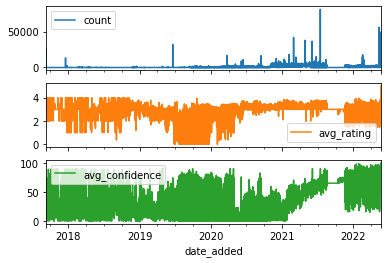

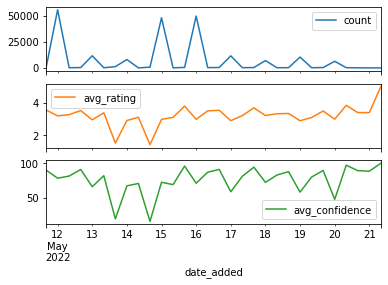

In [2]:
plot_cols = ['count', 'avg_rating', 'avg_confidence']
plot_features = df2[plot_cols]
plot_features.index = df2['date_added']
_ = plot_features.plot(subplots=True)

plot_features = df2[plot_cols][-30:]
plot_features.index = df2['date_added'][-30:]
_ = plot_features.plot(subplots=True)


In [3]:
df3 = df2.drop(['date_added'], axis=1)
df3

,count,avg_rating,avg_confidence
0,25533,3.633964,55.073904
1,22,3.000000,29.000000
2,1,2.000000,56.000000
3,1,3.000000,53.000000
4,5,4.000000,30.400000
...,...,...,...
5143,6353,2.992130,47.836140
5144,250,3.844000,97.196000
5145,75,3.400000,89.293333
5146,15,3.400000,88.533333


In [4]:
# split into train, test, validation
column_indices = {name: i for i, name in enumerate(df3.columns)}

n = len(df3)
train_df = df3[0:int(n*0.7)]
val_df = df3[int(n*0.7):int(n*0.9)]
test_df = df3[int(n*0.9):]

num_features = df3.shape[1]

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

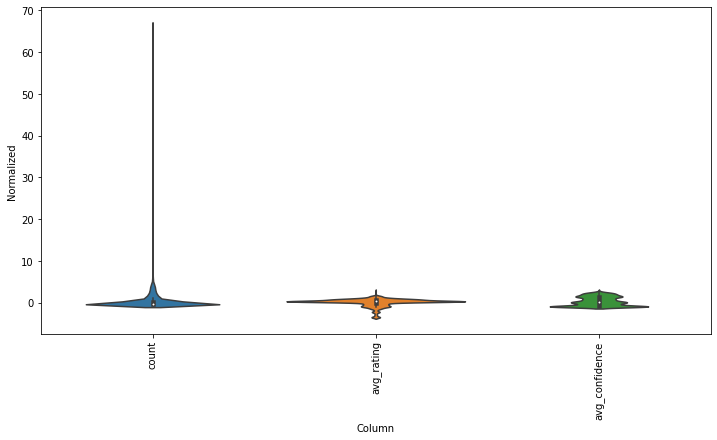

In [6]:
df_std = (df3 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df3.keys(), rotation=90)

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['avg_rating'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['avg_rating']

In [10]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


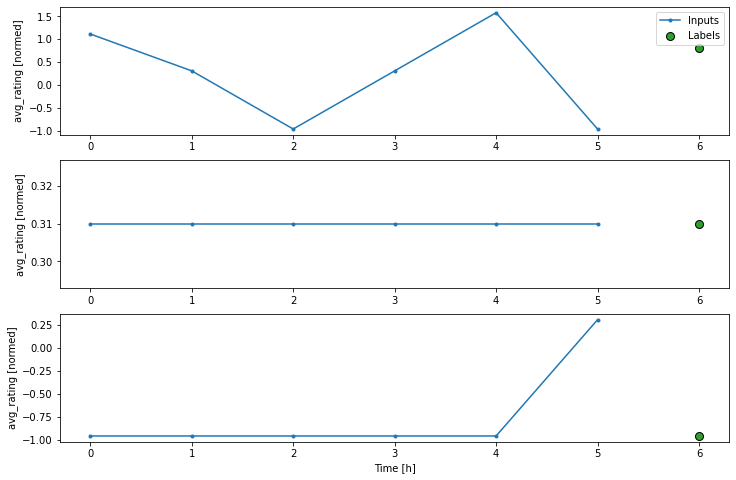

In [11]:
w2.example = example_inputs, example_labels
def plot(self, model=None, plot_col='avg_rating', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
w2.plot()

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def final(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_final', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._final = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['avg_rating'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['avg_rating']

In [17]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [18]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [19]:
baseline = Baseline(label_index=column_indices['avg_rating'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

33/33 [==============================] - 0s 2ms/step - loss: 0.2842 - mean_absolute_error: 0.3575


In [20]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['avg_rating'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['avg_rating']

In [21]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 3)
Output shape: (32, 30, 1)


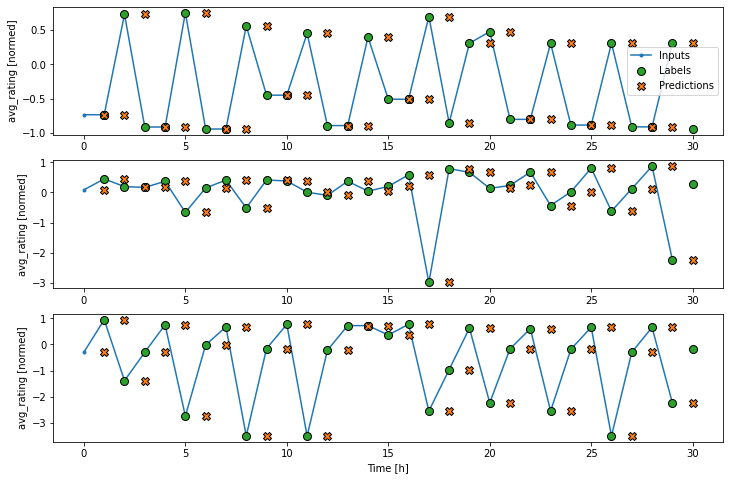

In [22]:
wide_window.plot(baseline)

In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [24]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [25]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 3)
Output shape: (32, 1, 1)


In [26]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
113/113 [==============================] - 1s 4ms/step - loss: 2.3577 - mean_absolute_error: 1.0906 - val_loss: 11.1698 - val_mean_absolute_error: 1.6502
Epoch 2/20
113/113 [==============================] - 0s 2ms/step - loss: 2.1369 - mean_absolute_error: 1.0254 - val_loss: 10.1294 - val_mean_absolute_error: 1.5504
Epoch 3/20
113/113 [==============================] - 0s 2ms/step - loss: 1.9699 - mean_absolute_error: 0.9759 - val_loss: 9.1628 - val_mean_absolute_error: 1.4566
Epoch 4/20
113/113 [==============================] - 0s 1ms/step - loss: 1.8347 - mean_absolute_error: 0.9368 - val_loss: 8.2812 - val_mean_absolute_error: 1.3677
Epoch 5/20
113/113 [==============================] - 0s 2ms/step - loss: 1.7258 - mean_absolute_error: 0.9073 - val_loss: 7.4639 - val_mean_absolute_error: 1.2843
Epoch 6/20
113/113 [==============================] - 0s 2ms/step - loss: 1.6364 - mean_absolute_error: 0.8838 - val_loss: 6.7201 - val_mean_absolute_error: 1.2043
Epoch 7/20
113

In [27]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 3)
Output shape: (32, 30, 1)


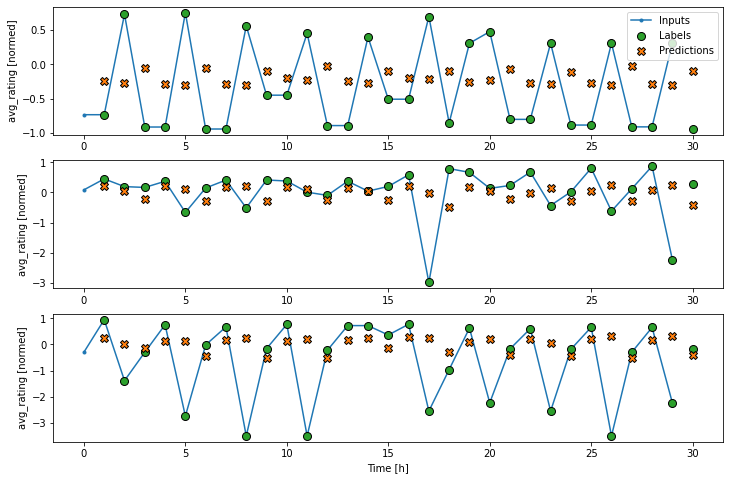

In [28]:
wide_window.plot(linear)

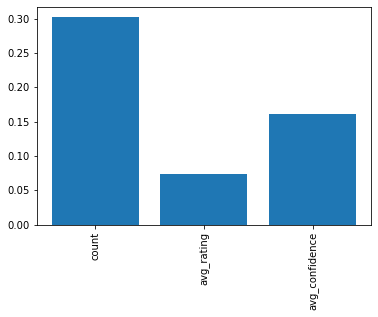

In [29]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [30]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
113/113 [==============================] - 1s 3ms/step - loss: 0.8812 - mean_absolute_error: 0.6549 - val_loss: 0.4045 - val_mean_absolute_error: 0.4548
Epoch 2/20
113/113 [==============================] - 0s 2ms/step - loss: 0.8248 - mean_absolute_error: 0.6347 - val_loss: 0.2919 - val_mean_absolute_error: 0.3564
Epoch 3/20
113/113 [==============================] - 0s 2ms/step - loss: 0.8004 - mean_absolute_error: 0.6220 - val_loss: 0.2688 - val_mean_absolute_error: 0.3493
Epoch 4/20
113/113 [==============================] - 0s 2ms/step - loss: 0.7845 - mean_absolute_error: 0.6137 - val_loss: 0.2702 - val_mean_absolute_error: 0.3429
Epoch 5/20
113/113 [==============================] - 0s 2ms/step - loss: 0.7736 - mean_absolute_error: 0.6136 - val_loss: 0.2638 - val_mean_absolute_error: 0.3429
Epoch 6/20
113/113 [==============================] - 0s 2ms/step - loss: 0.7644 - mean_absolute_error: 0.6080 - val_loss: 0.2643 - val_mean_absolute_error: 0.3438
Epoch 7/20
113/1

In [31]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['avg_rating'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['avg_rating']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

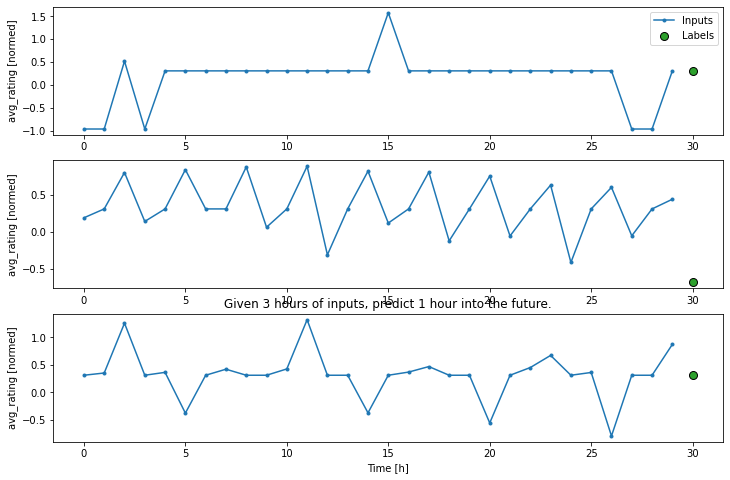

In [32]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [33]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [34]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 3)
Output shape: (32, 1, 1)


In [35]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 923us/step - loss: 0.4366 - mean_absolute_error: 0.4302


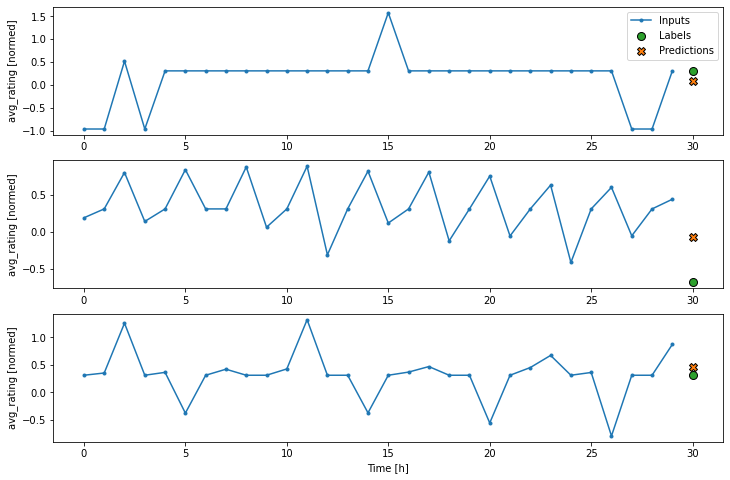

In [36]:
conv_window.plot(multi_step_dense)

In [37]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 3)
Output shape: (32, 1, 1)


In [38]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [39]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 3)
Output shape: (32, 1, 1)


In [40]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 990us/step - loss: 0.2267 - mean_absolute_error: 0.3196


In [41]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 3)
Labels shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [42]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['avg_rating'])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['avg_rating']

In [43]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 59, 3)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


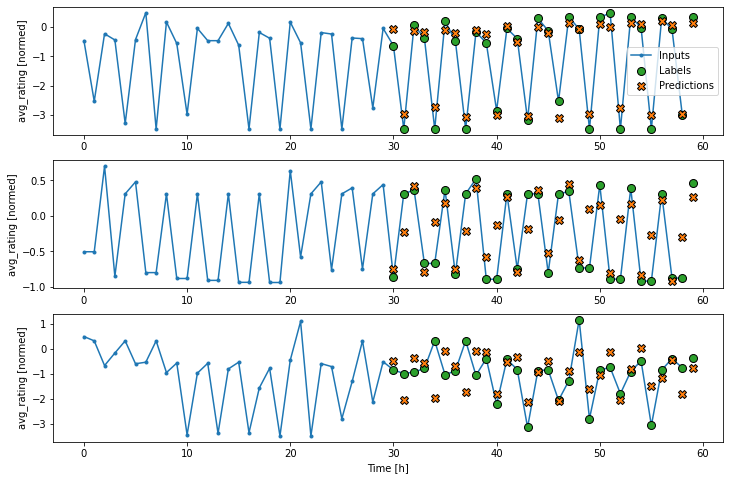

In [44]:
wide_conv_window.plot(conv_model)

In [45]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 3)
Output shape: (32, 30, 1)


In [47]:
wide_window.val

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>

In [48]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

32/32 [==============================] - 0s 4ms/step - loss: 0.1334 - mean_absolute_error: 0.2572


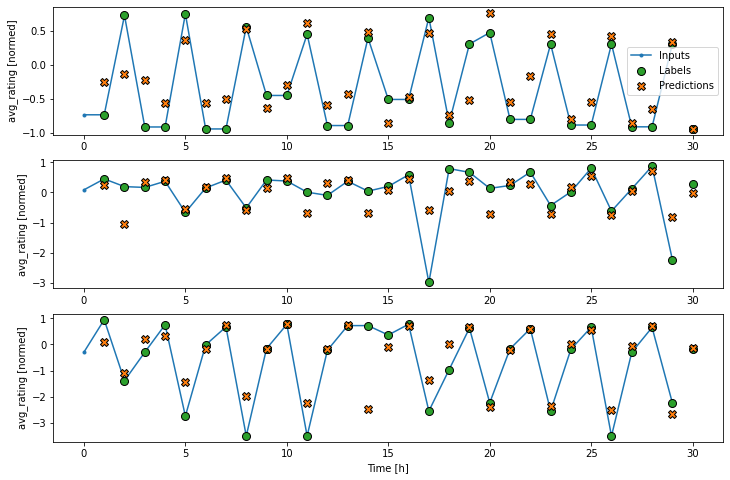

In [49]:
wide_window.plot(lstm_model)

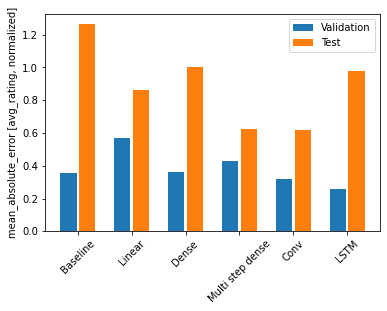

In [50]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [avg_rating, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [51]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.2641
Linear      : 0.8656
Dense       : 1.0022
Multi step dense: 0.6231
Conv        : 0.6197
LSTM        : 0.9774


In [52]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 24, 3)


In [53]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [54]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

32/32 [==============================] - 0s 1ms/step - loss: 6.9038 - mean_absolute_error: 0.9466


In [55]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [56]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

33/33 [==============================] - 0s 1ms/step - loss: 4.6867 - mean_absolute_error: 1.1088


In [57]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

32/32 [==============================] - 0s 3ms/step - loss: 3.8092 - mean_absolute_error: 0.8346

CPU times: total: 40.9 s
Wall time: 14.7 s


In [58]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [59]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

32/32 [==============================] - 0s 4ms/step - loss: 4.4047 - mean_absolute_error: 0.7792

CPU times: total: 1min 19s
Wall time: 26.1 s


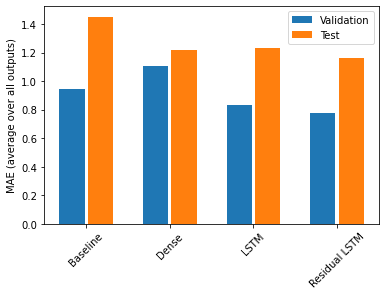

In [60]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

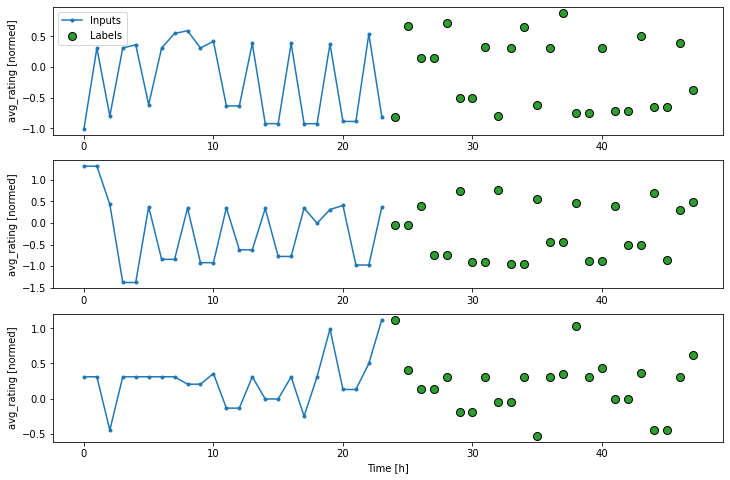

In [61]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

31/31 [==============================] - 0s 1ms/step - loss: 6.4818 - mean_absolute_error: 0.7843


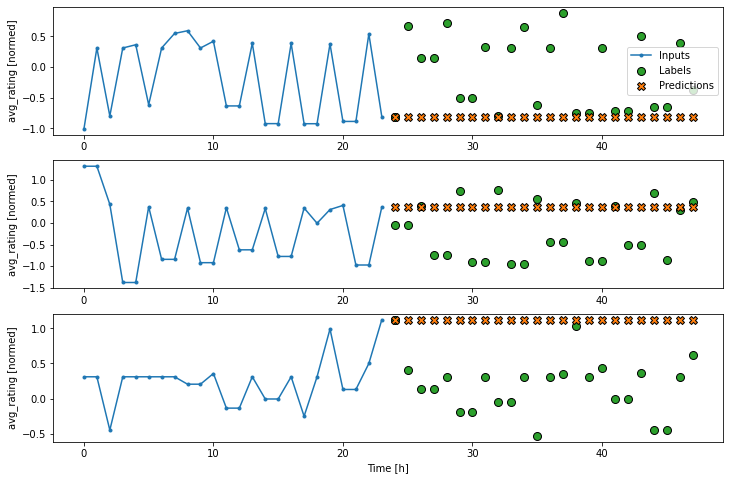

In [62]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

31/31 [==============================] - 0s 968us/step - loss: 5.3868 - mean_absolute_error: 0.4801


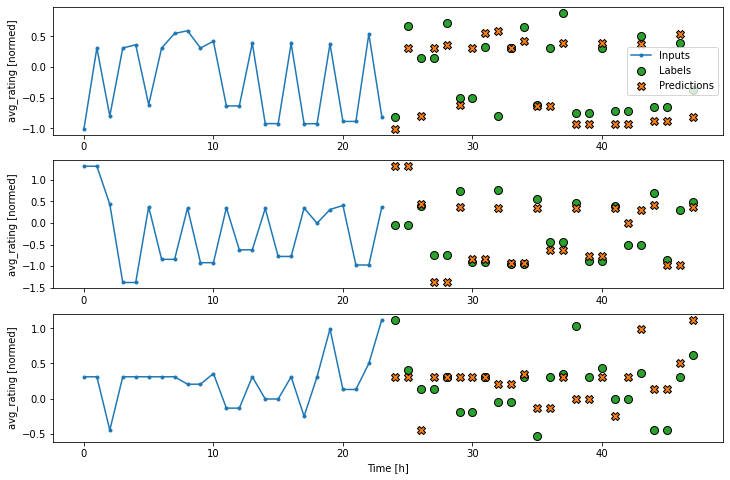

In [63]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

31/31 [==============================] - 0s 1ms/step - loss: 4.8589 - mean_absolute_error: 1.0455


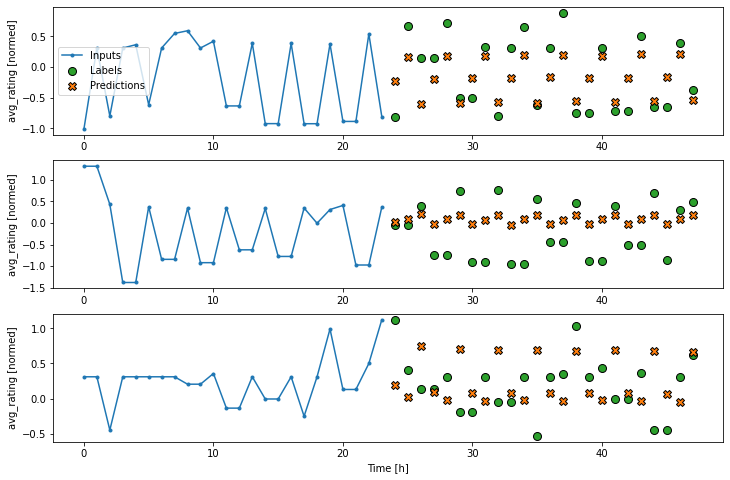

In [64]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

31/31 [==============================] - 0s 2ms/step - loss: 4.4176 - mean_absolute_error: 0.9786


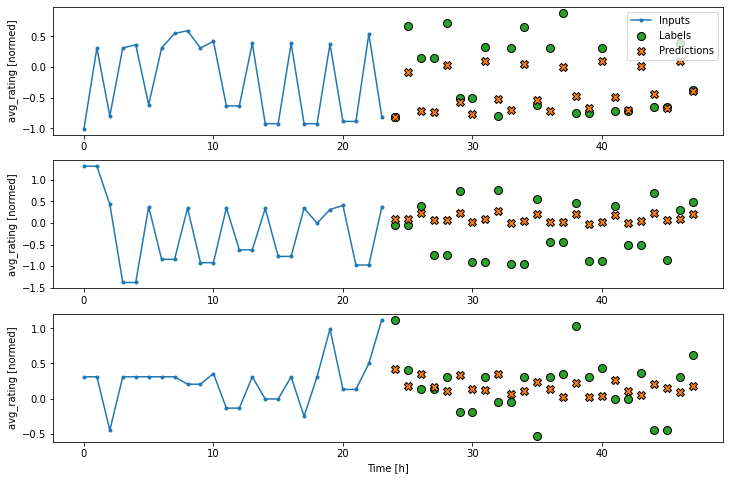

In [65]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

31/31 [==============================] - 0s 2ms/step - loss: 3.5788 - mean_absolute_error: 0.7444


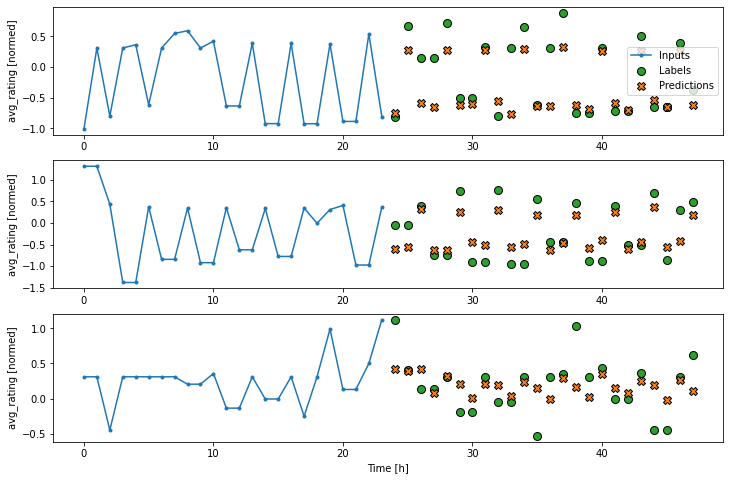

In [66]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

31/31 [==============================] - 0s 6ms/step - loss: 3.4236 - mean_absolute_error: 0.7485


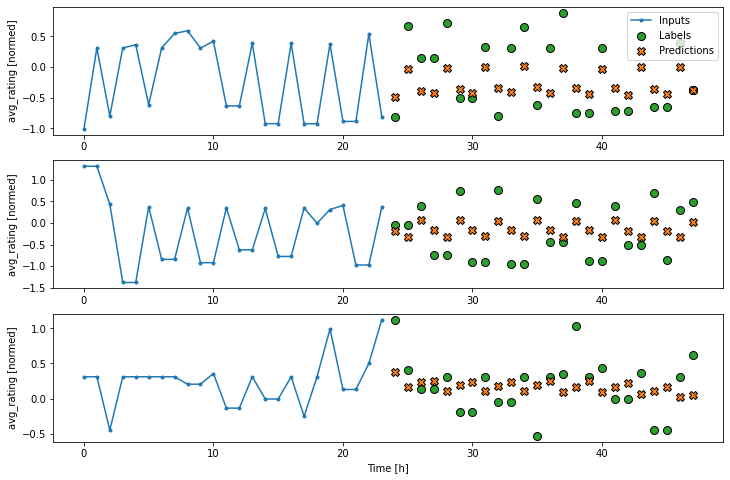

In [67]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [68]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [69]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [70]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [71]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 3])

In [72]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [73]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 3)


31/31 [==============================] - 0s 4ms/step - loss: 3.7978 - mean_absolute_error: 0.8841


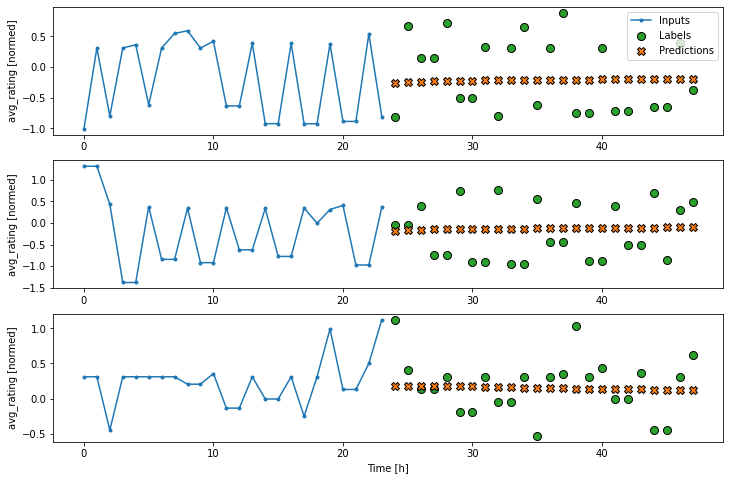

In [74]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

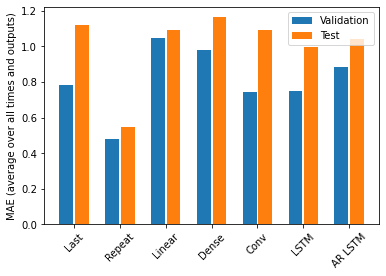

In [75]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [76]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
